In [2]:
import numpy as np
from gymnasium import spaces
import gymnasium as gym
import matplotlib.pyplot as plt

In [3]:
class SnakeGame(gym.Env):
    # other metadata avail, render.moldes unncessary if render() is not implemented
    metadata = {'render.modes' : ['console', 'rgb_array']}

    n_actions = 3

    # actions
    LEFT = 0
    STRAIGHT = 1
    RIGHT = 2

    # states
    EMPTY = 0
    SNAKE = 1
    WALL = 2
    FOOD = 3

    REWARD_WALL_HIT = -50
    REWARD_PER_STEP_TOWARDS_FOOD = 5 # avoid hitting walls on purpose
    REWARD_PER_FOOD = 100
    MAX_STEPS_AFTER_FOOD = 200 # avoid loop


    def grid_distance(self, pos1, pos2):
        # calculate euclidean distance between 2 points
        return np.linalg.norm(np.array(pos1, dtype=np.float32) - np.array(pos2, dtype=np.float32))

    
    def __init__(self, grid_size=20):
        super(SnakeGame, self).__init__()

        # steps init
        self.stepnum = 0
        self.last_food_step = 0

        # grid init
        self.grid_size = grid_size
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8) + self.EMPTY # EMPTY is zero so it doesn't matter (in case its not)
        
        # wall init
        self.grid[0, :] = self.WALL # UP
        self.grid[:, 0] = self.WALL # LEFT
        self.grid[self.grid_size - 1, :] = self.WALL # DOWN
        self.grid[:, self.grid_size - 1] = self.WALL # RIGHT

        # snake init
        # self.snake_coordinates = [ (1,1), (2,1) ]
        self.snake_coord = [(4, 3), (4, 4)] # top left

        for coord in self.snake_coord:
            self.grid[coord] = self.SNAKE

        # food init
        self.grid[3, 3] = self.FOOD

        # distance calculation
        self.head_dist_to_food = self.grid_distance(
            self.snake_coord[-1],
            np.argwhere(self.grid == self.FOOD)[0]
        )

        # save init setup
        self.init_grid = self.grid.copy()
        self.init_snake_coord = self.snake_coord.copy()

        # action space
        self.action_space = spaces.Discrete(self.n_actions)

        # observation(state) space
        self.observation_space = spaces.Dict(
            spaces={
                "position" : spaces.Box(low=0, high=(self.grid_size - 1), shape=(2,), dtype=np.int32),
                "direction" : spaces.Box(low=-1, high=1, shape=(2,), dtype=np.int32),
                "grid" : spaces.Box(low=0, high=3, shape=(self.grid_size * self.grid_size,), dtype=np.uint8)
            }
        )
    
    
    def reset(self, seed=None):
        import random
        # to init position
        self.stepnum = 0
        self.last_food_step = 0
        self.grid = self.init_grid.copy()
        self.snake_coord = self.init_snake_coord.copy()

        self.head_dist_to_food = self.grid_distance(
            self.snake_coord[-1],
            np.argwhere(self.grid == self.FOOD)[0]
        )

        if seed is not None:
            np.random.seed(seed)
        
        obs = self._get_obs() # state space
        info = {}

        return obs, info


    def _get_obs(self):
        position = np.array(self.snake_coord[-1], dtype=np.int32)
        direction = (np.array(self.snake_coord[-1]) - np.array(self.snake_coord[-2])).astype(np.int32)
        grid = self.grid.flatten()

        obs = {
            "position" : position,
            "direction" : direction,
            "grid" : grid
        }
        
        return obs
    

    def step(self, action):
        direction = np.array(self.snake_coord[-1]) - np.array(self.snake_coord[-2])

        if action == self.STRAIGHT:
            step = direction # towards the direction the snake faces
        elif action == self.RIGHT:
            # rotation matrix
            step = np.array( [direction[1], -direction[0]] )
        elif action == self.LEFT:
            step = np.array( [-direction[1], direction[0]] )
        
        # new head
        new_coord = (np.array(self.snake_coord[-1]) + step).astype(np.int32)

        if not (0 <= new_coord[0] < self.grid_size and 0 <= new_coord[1] < self.grid_size):
            return self._get_obs(), self.REWARD_WALL_HIT, True, False, {}

        self.snake_coord.append( (new_coord[0], new_coord[1]) )

        new_pos = self.snake_coord[-1]
        new_pos_type = self.grid[new_pos]
        self.grid[new_pos] = self.SNAKE

        done = False
        reward = 0 # calculated later

        if new_pos_type == self.FOOD:
            reward += self.REWARD_PER_FOOD
            self.last_food_step = self.stepnum

            # new food
            empty_tiles = np.argwhere(self.grid == self.EMPTY)

            if len(empty_tiles):
                new_food_pos = empty_tiles[np.random.randint(0, len(empty_tiles))]
                self.grid[new_food_pos[0], new_food_pos[1]] = self.FOOD
            else:
                done = True
            
        else:
            self.grid[self.snake_coord[0]] = self.EMPTY # empty the snake tail
            self.snake_coord = self.snake_coord[1:]

            if (new_pos_type == self.WALL) or (new_pos_type == self.SNAKE):
                done = True
                reward += self.REWARD_WALL_HIT
        
        head_dist_to_food_prev = self.head_dist_to_food
        self.head_dist_to_food = self.grid_distance(
            self.snake_coord[-1],
            np.argwhere(self.grid == self.FOOD)[0]
        )

        # reward for distance between snake <-> food
        if head_dist_to_food_prev > self.head_dist_to_food:
            reward += self.REWARD_PER_STEP_TOWARDS_FOOD
        elif head_dist_to_food_prev < self.head_dist_to_food:
            reward -= self.REWARD_PER_STEP_TOWARDS_FOOD * 2
        
        # max steps since no food
        if ((self.stepnum - self.last_food_step) > self.MAX_STEPS_AFTER_FOOD):
            done = True
        
        self.stepnum += 1

        # print(f"Step: {self.stepnum}, Action: {action}, Reward: {reward}, Done: {done}")
        # print(f"Snake Head: {self.snake_coord[-1]}, Distance to Food: {self.head_dist_to_food}")
        # print(f"New Position Type: {new_pos_type}")

        # return observation, reward, done, truncated, info
        return self._get_obs(), reward, done, False, {}


    def snake_plot(self, plot_inline=False):
        wall_idx = (self.grid == self.WALL)
        snake_idx = (self.grid == self.SNAKE)
        food_idx = (self.grid == self.FOOD)

        # colour array for plot
        colour_arr = np.zeros((self.grid_size, self.grid_size, 3), dtype=np.uint8) + 255 # default to white
        colour_arr[wall_idx, :] = np.array([0, 0, 0])
        colour_arr[snake_idx, :] = np.array([255, 196, 0])
        colour_arr[food_idx, :] = np.array([30, 47, 135])

        return colour_arr
    

    def render(self, mode='rgb_array'):
        if mode == 'console':
            print(self.grid)
        elif mode == 'rgb_array':
            return self.snake_plot()


In [4]:
# env check
from stable_baselines3.common.env_checker import check_env

env = SnakeGame()
check_env(env, warn=True)

In [5]:

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
import os

# log
log_dir = "../log"
os.makedirs(log_dir, exist_ok=True)

# env
env = SnakeGame()

# wrap env with monitor
env = Monitor(env, log_dir)

# cb fn -> periodically evaluate the model and save the best version
eval_cb = EvalCallback(env, best_model_save_path='../model',
                       log_path='../log',
                       eval_freq=5000,
                       deterministic=False,
                       render=False)

In [6]:
from stable_baselines3 import PPO
# Proximal Policy Optimization

# PPO hyperparam
PPO_model_args = {
    "learning_rate" : 0.002,
    "gamma" : 0.99, # discount factor for further rewards [0, 1]
    "verbose" : 0, # 1 -> more info on training steps
    "seed" : 523,
    "ent_coef" : 0.2, # entropy coef -> encourage exploration
    "clip_range" : 0.2 # limits p of action difference
}

# Multi Input Policy since we have 1+ states as an 'input'
model = PPO('MultiInputPolicy', env, **PPO_model_args)

if os.path.exists("../model/best_model.zip"):
    model.set_parameters("../model/best_model.zip")

model.learn(6000000, callback=eval_cb)
# model.learn(160000, callback=eval_cb)


KeyboardInterrupt: 

MovieWriter ffmpeg unavailable; using Pillow instead.


Step 1 
Action: 0 
Total Reward: 5
Step 2 
Action: 0 
Total Reward: 95
Step 3 
Action: 2 
Total Reward: 85
Step 4 
Action: 1 
Total Reward: 75
Step 5 
Action: 2 
Total Reward: 80
Step 6 
Action: 1 
Total Reward: 85
Step 7 
Action: 2 
Total Reward: 90
Step 8 
Action: 1 
Total Reward: 95
Step 9 
Action: 1 
Total Reward: 100
Step 10 
Action: 1 
Total Reward: 90
Step 11 
Action: 1 
Total Reward: 80
Step 12 
Action: 1 
Total Reward: 70
Step 13 
Action: 2 
Total Reward: 60
Step 14 
Action: 1 
Total Reward: 50
Step 15 
Action: 0 
Total Reward: 40
Step 16 
Action: 0 
Total Reward: 45
Step 17 
Action: 2 
Total Reward: 35
Step 18 
Action: 2 
Total Reward: 25
Step 19 
Action: 2 
Total Reward: 30
Step 20 
Action: 1 
Total Reward: 35
Step 21 
Action: 0 
Total Reward: 25
Step 22 
Action: 1 
Total Reward: 15
Step 23 
Action: 1 
Total Reward: -45
Game Over! Total Reward: -45


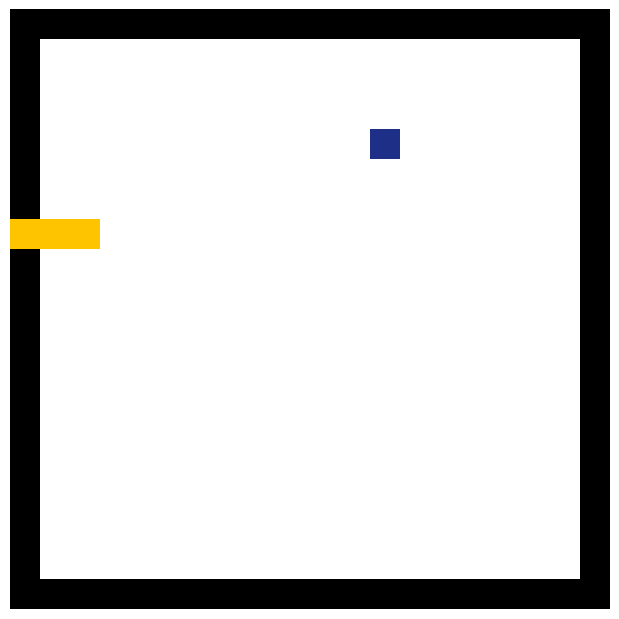

In [251]:
import matplotlib.animation as animation
import matplotlib as mpl

# test
obs, _ = env.reset()

# for img gif
fig, ax = plt.subplots(figsize=(6, 6))
plt.axis('off')
frames = []
fps = 18

n_steps = 1000000
total_reward = 0

for step in range(n_steps):
    # preprocess the obs to match the model's input format
    action, _ = model.predict(obs, deterministic=False)
    obs, reward, done, trunc, info = env.step(action)
    
    total_reward += reward

    print(f"Step {step + 1} \nAction: {action} \nTotal Reward: {total_reward}")
    
    frames.append([ax.imshow(env.unwrapped.render(mode='rgb_array'), animated=True)])

    if done:
        print(f"Game Over! Total Reward: {total_reward}")
        break

fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

anim = animation.ArtistAnimation(fig, frames, interval=int(1000/fps), blit=True, repeat_delay=1000)
anim.save("../snake_game.gif", dpi=150)